# Import Modules

In [211]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
import tensorflow as tf
from tqdm import tqdm, tqdm_notebook
from utils import emphasis
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence

import numpy as np
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
import matplotlib.pyplot as plt

print(tf.test.is_gpu_available())

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False


# SRCNN

## Model Definition

In [212]:
class SubPixel1D(tf.keras.layers.Layer):
    def __init__(self, r=2):
        super(SubPixel1D, self).__init__()
        self.r = r
    def call(self, I):
        """One-dimensional subpixel upsampling layer
        Calls a tensorflow function that directly implements this functionality.
         We assume input has dim (batch, width, r)
        """
        X = tf.transpose(I, [2,1,0]) # (r, w, b)
        X = tf.batch_to_space_nd(X, [self.r], [[0,0]]) # (1, r*w, b)
        X = tf.transpose(X, [2,1,0])
        return X

noisy = tf.keras.layers.Input(shape=(None, 1))
x_input = noisy
x = x_input

# B = 8
# n_filters = [128, 256, 512, 512, 512, 512, 512, 512]
# kernel_sizes = [65, 33, 17, 9, 9, 9, 9, 9]

B = 4
n_filters = [128, 256, 512, 512]
kernel_sizes = [65, 33, 17, 9]

# B = 3
# n_filters = [128, 256, 512]
# kernel_sizes = [65, 33, 17]

# B = 3
# n_filters = [64, 128, 256]
# kernel_sizes = [65, 33, 17]


# Downsampling Layers
encoder_features = []
for k, n_filter, kernel_size in zip(range(B), n_filters, kernel_sizes):
    x = tf.keras.layers.Conv1D(filters = n_filter,
                               kernel_size = kernel_size,
                               strides = 2,
                               padding = 'same',
                               kernel_initializer = 'Orthogonal')(x)
    # x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.LeakyReLU(0.2)(x)
    encoder_features.append(x)
    
# Bottleneck Layer
x = tf.keras.layers.Conv1D(filters = 512,
                           kernel_size = 9,
                           strides = 2,
                           padding = 'same',
                           kernel_initializer = 'Orthogonal')(x)
x = tf.keras.layers.Dropout(rate=0.5)(x)
# x = tf.keras.layers.PReLU()(x)
x = tf.keras.layers.LeakyReLU(0.2)(x)

# Upsampling Layer
for k, n_filter, kernel_size, enc in reversed(list(zip(range(B), 
                                                  n_filters, 
                                                  kernel_sizes, 
                                                  encoder_features))):
    x = tf.keras.layers.Conv1D(filters = n_filter,
                               kernel_size = kernel_size,
                               strides = 1,
                               padding = 'same',
                               kernel_initializer = 'Orthogonal')(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    # x = tf.keras.layers.PReLU()(x)
    x = tf.keras.layers.ReLU()(x)
    x = SubPixel1D()(x)
    x = tf.keras.layers.Concatenate(axis=2)([x, enc])

# Final Conv Layer
x = tf.keras.layers.Conv1D(filters = 2,
                           kernel_size = 9,
                           strides = 1,
                           padding = 'same')(x)
x = SubPixel1D()(x)
x_final = tf.keras.layers.Add()([x, x_input])    
G = tf.keras.models.Model(inputs = [noisy], outputs = [x_final], name='SubPixel1D')    

## Load Model

In [291]:
optim = tf.keras.optimizers.Adam(lr=1e-4)
def G_loss(true, fake):
    return 1 * K.sqrt(K.mean((fake - true) ** 2))

G.compile(loss = G_loss,
          optimizer = optim)

G.load_weights('./model/weights_VCTKsingle.hdf5')

# Predict

In [292]:
sample_rate = 16000

y_clean, fs = sf.read('../dataset/VCTK_singlespeaker_clean/train/p225_003.wav')
y_noisy, fs = sf.read('../dataset/VCTK_singlespeaker_cubic/train/p225_003.wav')

# y_clean, fs = sf.read('../dataset/VCTK_singlespeaker_clean/test/p225_356.wav')
# y_noisy, fs = sf.read('../dataset/VCTK_singlespeaker_cubic/test/p225_356.wav')

# y_clean, fs = sf.read('../dataset/timit_clean_new/test/DR1_MDAB0_SA2.wav')
# y_noisy, fs = sf.read('../dataset/timit_cubic_new/test/DR1_MDAB0_SA2.wav')

# y_clean, fs = sf.read('../dataset/timit_clean_new/train/DR1_FCJF0_SA1.wav')
# y_noisy, fs = sf.read('../dataset/timit_cubic_new/train/DR1_FCJF0_SA1.wav')
y_pred = G.predict(y_noisy[:-(len(y_noisy) % (2 ** 5))].reshape(1, -1, 1), batch_size = 1)
y_pred = y_pred.reshape(-1)

y_clean = y_clean[:len(y_pred)]
y_noisy = y_noisy[:len(y_pred)]

High Resolution

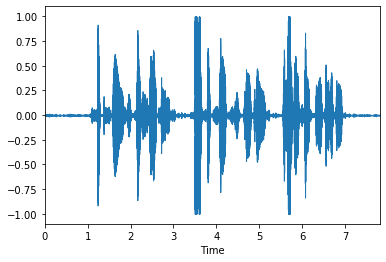

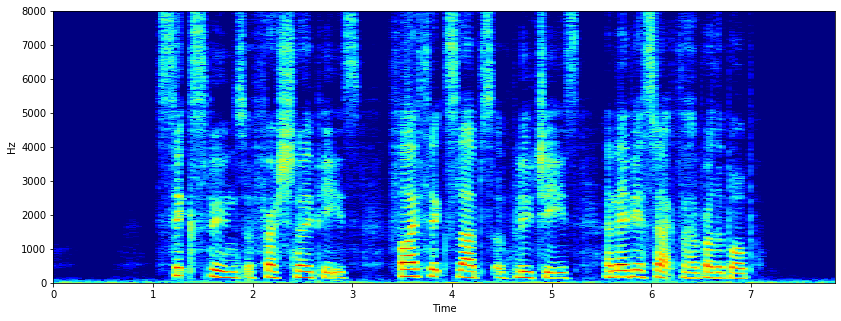

In [284]:
librosa.display.waveplot(y_clean, sr = fs)

D_clean = librosa.stft(y_clean)
D_clean_db = librosa.amplitude_to_db(abs(D_clean))
plt.figure(figsize=(14,5))
librosa.display.specshow(D_clean_db, sr=fs, x_axis='time', y_axis='hz', cmap='jet')

ipd.Audio(y_clean, rate = fs)

Low Resolution

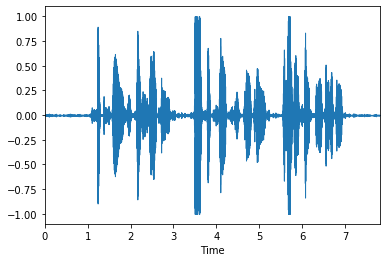

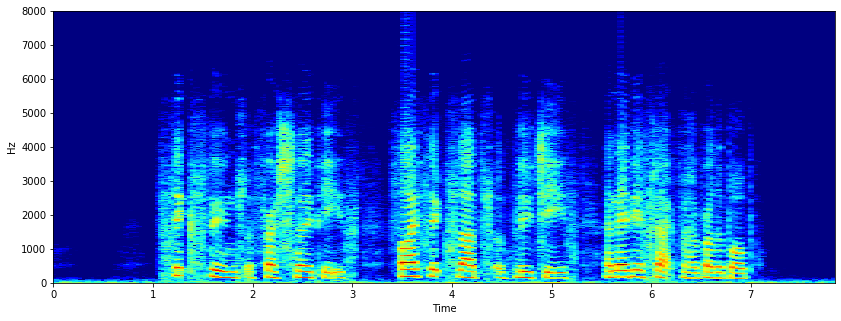

In [285]:


librosa.display.waveplot(y_noisy, sr = fs)

D_noisy = librosa.stft(y_noisy)
D_noisy_db = librosa.amplitude_to_db(abs(D_noisy))
plt.figure(figsize=(14,5))
librosa.display.specshow(D_noisy_db, sr=fs, x_axis='time', y_axis='hz', cmap='jet')

ipd.Audio(y_noisy, rate = fs)

Precited

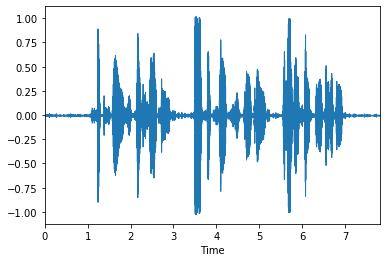

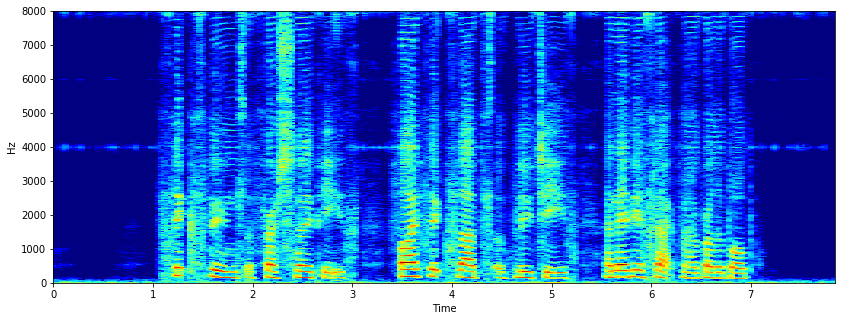

In [293]:

librosa.display.waveplot(y_pred, sr = sample_rate)

D_pred = librosa.stft(y_pred)
D_pred_db = librosa.amplitude_to_db(abs(D_pred))
plt.figure(figsize=(14,5))
librosa.display.specshow(D_pred_db, sr=sample_rate, x_axis='time', y_axis='hz', cmap='jet')

ipd.Audio(y_pred, rate = sample_rate)

In [294]:
def SNR(y_true, y_pred):
    n_norm = np.mean((y_true - y_pred) ** 2)
    s_norm = np.mean(y_true ** 2)
    return 10 * np.log(s_norm / n_norm)

print(SNR(y_clean, y_pred), SNR(y_clean, y_noisy))

43.22585458950737 45.42620532206634


In [296]:
def LSD(y_true, y_pred):
    '''
    Compute the Log-Spectral Divergence
    
    Parameters
    ----------
    y_true, y_pred: np.array
    - Speech array
    
    Returns
    -------
    divergence: float
    '''
    
    D_true = librosa.stft(y_true, n_fft = 2048)
    D_true_db = librosa.core.amplitude_to_db(D_true)
    D_pred = librosa.stft(y_pred, n_fft = 2048)
    D_pred_db = librosa.core.amplitude_to_db(D_pred)
    
    divergence = np.mean(np.mean((D_true_db - D_pred_db) ** 2, axis = 0) ** 0.5)
    return divergence

print(LSD(y_clean, y_pred), LSD(y_clean, y_noisy))

6.7007074 6.737133


In [264]:
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

print(RMSE(y_clean[10000:18192], y_pred[10000:18192]), RMSE(y_clean[10000:18192], y_noisy[10000:18192]))

0.0004833327412161599 3.229141798655894e-05
